# Importing Libraries

In [1]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

In [22]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated, Literal, Optional

@tool
def get_weather(location: str):
    """Call to get the current weather"""
    if location.lower() in ['bengaluru']:
        return "15 degree"
    return "30 degree"


tools = [get_weather]
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000014794FD4B60>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000014794F7B4A0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_weather', 'description': 'Call to get the current weather', 'parameters': {'properties': {'location': {'type': 'string'}}, 'required': ['location'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [32]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal['tools', END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

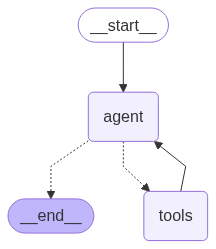

In [33]:
workflow = StateGraph(MessagesState)

tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, )
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=MemorySaver())
graph

In [34]:
from langchain_core.messages import HumanMessage
graph.invoke(
    {"messages": [HumanMessage(content="How is the weather in Bengaluru?")]}, 
    config={"configurable": {"thread_id": 1}}
)

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='83780481-e1ad-4914-9452-4a9e56b2cc5e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'j0h3p76fg', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 131, 'total_tokens': 241, 'completion_time': 0.40593823, 'prompt_time': 0.021011953, 'queue_time': 0.048339957, 'total_time': 0.426950183}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9574048e-4dc5-45f9-8d2d-dfdeefa28e99-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'j0h3p76fg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 110, 'total_tokens': 241}),
  ToolMessage(content='15 degree', name='get_weather', id='3787

In [35]:
graph.invoke(
    {"messages": [HumanMessage(content="What would you recommend to do in the city then?")]}, 
    config={"configurable": {"thread_id": 1}}
)

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='83780481-e1ad-4914-9452-4a9e56b2cc5e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'j0h3p76fg', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 131, 'total_tokens': 241, 'completion_time': 0.40593823, 'prompt_time': 0.021011953, 'queue_time': 0.048339957, 'total_time': 0.426950183}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9574048e-4dc5-45f9-8d2d-dfdeefa28e99-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'j0h3p76fg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 110, 'total_tokens': 241}),
  ToolMessage(content='15 degree', name='get_weather', id='3787

# Async and Streaming: Production Ready

In [43]:
async def call_model(state: MessagesState):
    messages = state['messages']
    response = await llm_with_tools.ainvoke(messages)
    return {"messages": [response]}


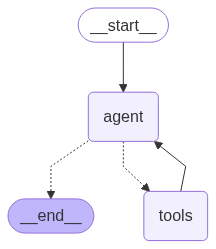

In [44]:
workflow = StateGraph(MessagesState)

tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, {"tools": "tools", END: END})
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=MemorySaver())
graph

In [45]:
inputs = {"messages": [HumanMessage(content="How is the weather in Bengaluru?")]}
config = {"configurable": {"thread_id": 2}}

In [46]:
await graph.ainvoke(input=inputs, config=config)

{'messages': [HumanMessage(content='How is the weather in Bengaluru?', additional_kwargs={}, response_metadata={}, id='240bdcfa-3e46-4eae-8a1a-52c7a68548d2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'brbdapxzs', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 189, 'prompt_tokens': 131, 'total_tokens': 320, 'completion_time': 0.66810227, 'prompt_time': 0.021110473, 'queue_time': 0.047685577, 'total_time': 0.689212743}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b8d316bd-b3e1-4194-8722-9e8544e0cf79-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'brbdapxzs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 189, 'total_tokens': 320}),
  ToolMessage(content='15 degree', name='get_weather', id='5aa9

In [47]:
inputs = {"messages": [HumanMessage(content="How is the weather in Bengaluru?")]}
async for output in graph.astream(inputs, stream_mode="updates", config=config):
    for key, value in output.items():
        print(f"Output from node '{key}'")
        print("---"*7)
        print(value['messages'][-1].pretty_print())


Output from node 'agent'
---------------------
================================== Ai Message ==================================
Tool Calls:
  get_weather (52pwab9jr)
 Call ID: 52pwab9jr
  Args:
    location: Bengaluru
None
Output from node 'tools'
---------------------
================================= Tool Message =================================
Name: get_weather

15 degree
None
Output from node 'agent'
---------------------
================================== Ai Message ==================================
Tool Calls:
  get_weather (52pwab9jr)
 Call ID: 52pwab9jr
  Args:
    location: Bengaluru
None
Output from node 'tools'
---------------------
================================= Tool Message =================================
Name: get_weather

15 degree
None
Output from node 'agent'
---------------------
================================== Ai Message ==================================

The current temperature in Bengaluru remains at 15 degrees Celsius.
None


In [48]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = [HumanMessage(content="How is the weather in Bengaluru?")]
gathered = None

async for msg, metadata in graph.astream({"messages": inputs}, stream_mode="messages", config=config):
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="|", flush=True)

    if isinstance(msg, AIMessageChunk):
        if gathered is None:
            gathered = msg
        else:
            gathered += msg

The| weather| in| Bengal|uru| is| currently| |15| degrees| Celsius|.| It| seems| quite| cool| at| the| moment|!|

In [49]:
print(gathered.content)

The weather in Bengaluru is currently 15 degrees Celsius. It seems quite cool at the moment!
